<a href="https://colab.research.google.com/github/shivendr7/ml/blob/GANs/LSGAN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels)=mnist.load_data()

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Conv2D, Dense, Conv2DTranspose, BatchNormalization, LeakyReLU, Flatten, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [100]:
def build_discriminator():
  init=RandomNormal(stddev=0.02)
  model=Sequential()
  model.add(Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=(28,28,1)))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dense(1, activation='linear', kernel_initializer=init))
  opt=Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
  return model
disc=build_discriminator()

In [101]:
def build_generator(latent_dim):
  init=RandomNormal(stddev=0.2)
  model=Sequential()
  model.add(Dense(256*7*7, input_shape=latent_dim, kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Reshape(target_shape=(7,7,256)))
  model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(1, kernel_size=(7,7), padding='same', kernel_initializer=init))
  model.add(Activation('tanh'))
  return model
gen=build_generator(latent_dim=(100,))

In [102]:
gen.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_29 (Batc (None, 12544)             50176     
_________________________________________________________________
activation_16 (Activation)   (None, 12544)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 14, 14, 128)       524416    
_________________________________________________________________
batch_normalization_30 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
activation_17 (Activation)   (None, 14, 14, 128)     

In [103]:
disc.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 14, 14, 64)        1088      
_________________________________________________________________
batch_normalization_27 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 64)          65600     
_________________________________________________________________
batch_normalization_28 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3136)            

In [104]:
def build_gan():
  disc.trainable=False
  model=Sequential()
  model.add(gen)
  model.add(disc)
  opt=Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
  return model
gan=build_gan()

In [105]:
X=np.expand_dims(train_images, axis=-1)
Xf=X.astype('float32')
Xf=(Xf-127.5)/127.5

In [106]:
disc.predict(Xf[0].reshape(1,28,28,1))

array([[0.04797098]], dtype=float32)

In [107]:
def generate_real_samples(n):
  ix=np.random.randint(0, Xf.shape[0], n)
  x=Xf[ix]
  y=np.ones(shape=(n,1))
  return x,y
x_1, y_1=generate_real_samples(10)
x_1.shape, y_1.shape

((10, 28, 28, 1), (10, 1))

In [108]:
def generate_latent_points(n):
  return np.random.randn(100*n).reshape(n,100)
def generate_fake_samples(n):
  x=generate_latent_points(n)
  x=gen.predict(x)
  y=np.zeros(shape=(n,1))
  return x,y
x_1, y_1=generate_fake_samples(10)
x_1.shape, y_1.shape

((10, 28, 28, 1), (10, 1))

In [109]:
def summarise_performance(step):
  x,_ =generate_fake_samples(5)
  x=(x+1)/2 #[-1,1]->[0,1]
  for i in range(5):
    plt.subplot(20,5,step*5+i+1)
    plt.axis('off')
    plt.imshow(x[i,:,:,0], cmap='gray_r')

In [110]:
d1_hist=[];d2_hist=[];g_hist=[];a1_hist=[];a2_hist=[]

In [111]:
def plot_history():
  plt.subplot(2,1,1)
  plt.plot(d1_hist, label='d_real')
  plt.plot(d2_hist, label='d_fake')
  plt.plot(g_hist, label='gen')
  plt.legend()
  plt.subplot(2,1,2) 
  plt.plot(a1_hist, label='acc_real')
  plt.plot(a2_hist, label='acc_fake')
  plt.legend()
  #plt.close()

In [112]:
def train(n_epochs=20, n_batch=64):
  batch_per_epoch=Xf.shape[0]//n_batch
  half_batch=n_batch//2
  n=batch_per_epoch*n_epochs
  
  for i in range(n):
    x_r, y_r=generate_real_samples(half_batch)
    d_loss1, d_acc1=disc.train_on_batch(x_r, y_r)
    x_f, y_f=generate_fake_samples(half_batch)
    d_loss2, d_acc2=disc.train_on_batch(x_f, y_f)
    x_g=generate_latent_points(n_batch)
    y_g=np.ones(shape=(n_batch,1))
    g_loss, _ =gan.train_on_batch(x_g, y_g)
    print('%d d1=[%.3f] d2=[%.3f] g=[%.3f] a1=[%d] a2=[%d]'%(i+1,d_loss1, d_loss2, g_loss, d_acc1*100, d_acc2*100))
    d1_hist.append(d_loss1)
    d2_hist.append(d_loss2)
    g_hist.append(g_loss)
    a1_hist.append(d_acc1)
    a2_hist.append(d_acc2)
    """
    if((i+1)%batch_per_epoch==0):
      summarise_performance((i+1)//batch_per_epoch) """

In [113]:
train(10)

1 d1=[0.202] d2=[0.590] g=[0.958] a1=[78] a2=[65]
2 d1=[0.677] d2=[0.306] g=[0.957] a1=[93] a2=[93]
3 d1=[1.254] d2=[0.222] g=[0.931] a1=[6] a2=[87]
4 d1=[0.356] d2=[0.494] g=[0.941] a1=[100] a2=[68]
5 d1=[0.207] d2=[0.300] g=[0.958] a1=[96] a2=[68]
6 d1=[0.237] d2=[0.508] g=[0.945] a1=[75] a2=[93]
7 d1=[0.185] d2=[0.309] g=[0.949] a1=[93] a2=[65]
8 d1=[0.213] d2=[0.333] g=[0.954] a1=[96] a2=[100]
9 d1=[0.328] d2=[0.314] g=[0.960] a1=[53] a2=[71]
10 d1=[0.308] d2=[0.349] g=[0.965] a1=[96] a2=[81]
11 d1=[0.125] d2=[0.217] g=[0.966] a1=[93] a2=[87]
12 d1=[0.334] d2=[0.184] g=[0.944] a1=[75] a2=[93]
13 d1=[0.308] d2=[0.294] g=[0.959] a1=[96] a2=[78]
14 d1=[0.179] d2=[0.292] g=[0.941] a1=[84] a2=[90]
15 d1=[0.181] d2=[0.350] g=[0.965] a1=[96] a2=[62]
16 d1=[0.306] d2=[0.256] g=[0.937] a1=[53] a2=[96]
17 d1=[0.508] d2=[0.424] g=[0.971] a1=[100] a2=[68]
18 d1=[0.612] d2=[0.262] g=[0.959] a1=[28] a2=[87]
19 d1=[0.419] d2=[0.300] g=[0.951] a1=[100] a2=[96]
20 d1=[0.194] d2=[0.327] g=[0.949] a1

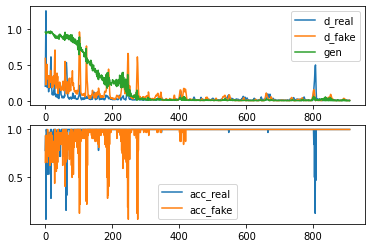

In [114]:
plot_history()

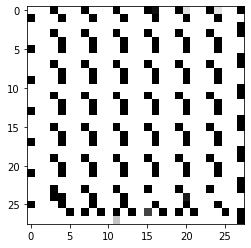

In [115]:
x,_ =generate_fake_samples(2)
plt.imshow(x[0].reshape(28,28), cmap='gray_r')